In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression


/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv


In [2]:
os.listdir('../input/ieee-fraud-detection')


['test_identity.csv',
 'sample_submission.csv',
 'train_identity.csv',
 'train_transaction.csv',
 'test_transaction.csv']

In [3]:
train_iden_df = pd.read_csv("../input/ieee-fraud-detection/train_identity.csv")
train_trans_df = pd.read_csv("../input/ieee-fraud-detection/train_transaction.csv")
test_trans_df = pd.read_csv("../input/ieee-fraud-detection/test_transaction.csv")
test_iden_df = pd.read_csv("../input/ieee-fraud-detection/test_identity.csv")

In [5]:
print('Dimensions of the Train Identity set:',train_iden_df.shape)
print('Dimensions of the Train transaction set:',train_trans_df.shape)
print('Dimensions of the Test transaction set:',test_trans_df.shape)
print('Dimensions of the Test Identity set:',test_iden_df.shape)

Dimensions of the Train Identity set: (144233, 41)
Dimensions of the Train transaction set: (590540, 394)
Dimensions of the Test transaction set: (506691, 393)
Dimensions of the Test Identity set: (141907, 41)


In [7]:
train_iden_df.head()


,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [8]:
train_trans_df.head()


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
train_trans_df['TransactionID'].isin(train_iden_df['TransactionID'].unique())
# np.sum(train_trans_df['TransactionID'].isin(train_iden_df['TransactionID'].unique()),axis=0)

0         False
1         False
2         False
3         False
4          True
          ...  
590535    False
590536    False
590537    False
590538    False
590539    False
Name: TransactionID, Length: 590540, dtype: bool

In [10]:
print(np.sum(train_trans_df['TransactionID'].isin(train_iden_df['TransactionID'].unique())))
print(np.sum(test_trans_df['TransactionID'].isin(test_iden_df['TransactionID'].unique())))


144233
141907


In [13]:
test_df = pd.merge(test_trans_df, test_iden_df, how = "left", on="TransactionID")
train_df = pd.merge(train_trans_df, train_trans_df, how="left", on="TransactionID")

In [14]:
print("Test Dataset shape: ", test_df.shape)
print("Train Dataset shape: ", train_df.shape)


Test Dataset shape:  (506691, 433)
Train Dataset shape:  (590540, 787)


In [38]:
train_df.head()


,TransactionID,isFraud_x,TransactionDT_x,TransactionAmt_x,ProductCD_x,card1_x,card2_x,card3_x,card4_x,card5_x,...,V330_y,V331_y,V332_y,V333_y,V334_y,V335_y,V336_y,V337_y,V338_y,V339_y
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
test_df.head()


,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# This Step is done to reduce memory by conversion
# convert it to the low memory to fit the RAM
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [20]:
train_df=reduce_mem_usage(train_df)
test_df=reduce_mem_usage(test_df)

Mem. usage decreased to 1086.94 Mb (69.4% reduction)
Mem. usage decreased to 565.37 Mb (66.3% reduction)


In [21]:
for col_name in train_df.columns:
    if train_df[col_name].dtypes == 'object':
        unique_cat = len(train_df[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

Feature 'ProductCD_x' has 5 categories
Feature 'card4_x' has 5 categories
Feature 'card6_x' has 5 categories
Feature 'P_emaildomain_x' has 60 categories
Feature 'R_emaildomain_x' has 61 categories
Feature 'M1_x' has 3 categories
Feature 'M2_x' has 3 categories
Feature 'M3_x' has 3 categories
Feature 'M4_x' has 4 categories
Feature 'M5_x' has 3 categories
Feature 'M6_x' has 3 categories
Feature 'M7_x' has 3 categories
Feature 'M8_x' has 3 categories
Feature 'M9_x' has 3 categories
Feature 'ProductCD_y' has 5 categories
Feature 'card4_y' has 5 categories
Feature 'card6_y' has 5 categories
Feature 'P_emaildomain_y' has 60 categories
Feature 'R_emaildomain_y' has 61 categories
Feature 'M1_y' has 3 categories
Feature 'M2_y' has 3 categories
Feature 'M3_y' has 3 categories
Feature 'M4_y' has 4 categories
Feature 'M5_y' has 3 categories
Feature 'M6_y' has 3 categories
Feature 'M7_y' has 3 categories
Feature 'M8_y' has 3 categories
Feature 'M9_y' has 3 categories


In [22]:
train_df.describe()

,TransactionID,isFraud_x,TransactionDT_x,TransactionAmt_x,card1_x,card2_x,card3_x,card5_x,addr1_x,addr2_x,...,V330_y,V331_y,V332_y,V333_y,V334_y,V335_y,V336_y,V337_y,V338_y,V339_y
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.0,588975.0,586281.0,524834.0,524834.0,...,82351.000000,82351.000000,82351.000000,82351.000000,82351.0,82351.0,82351.0,82351.000000,82351.000000,82351.000000
mean,3.282270e+06,0.034990,7.372311e+06,NaN,9898.734658,NaN,NaN,NaN,NaN,NaN,...,0.775391,721.741455,1375.778564,1014.619934,NaN,NaN,NaN,55.352417,151.160538,100.700874
std,1.704744e+05,0.183755,4.617224e+06,NaN,4901.170153,NaN,0.0,0.0,NaN,0.0,...,0.000000,6217.229980,11169.515625,7955.782227,NaN,NaN,NaN,668.375854,1095.057739,814.953247
min,2.987000e+06,0.000000,8.640000e+04,0.250977,1000.000000,100.0,100.0,100.0,100.0,10.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
25%,3.134635e+06,0.000000,3.027058e+06,43.312500,6019.000000,214.0,150.0,166.0,204.0,87.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
50%,3.282270e+06,0.000000,7.306528e+06,68.750000,9678.000000,361.0,150.0,226.0,299.0,87.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,14184.000000,512.0,150.0,226.0,330.0,87.0,...,0.000000,0.000000,25.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
max,3.577539e+06,1.000000,1.581113e+07,31936.000000,18396.000000,600.0,231.0,237.0,540.0,102.0,...,55.000000,160000.000000,160000.000000,160000.000000,55136.0,55136.0,55136.0,104060.000000,104060.000000,104060.000000


In [24]:
cat_cols = [col for col in train_df.columns if train_df[col].dtypes == 'object']
train_df[cat_cols].describe()

,ProductCD_x,card4_x,card6_x,P_emaildomain_x,R_emaildomain_x,M1_x,M2_x,M3_x,M4_x,M5_x,...,R_emaildomain_y,M1_y,M2_y,M3_y,M4_y,M5_y,M6_y,M7_y,M8_y,M9_y
count,590540,588963,588969,496084,137291,319440,319440,319440,309096,240058,...,137291,319440,319440,319440,309096,240058,421180,244275,244288,244288
unique,5,4,4,59,60,2,2,2,3,2,...,60,2,2,2,3,2,2,2,2,2
top,W,visa,debit,gmail.com,gmail.com,T,T,T,M0,F,...,gmail.com,T,T,T,M0,F,F,F,F,T
freq,439670,384767,439938,228355,57147,319415,285468,251731,196405,132491,...,57147,319415,285468,251731,196405,132491,227856,211374,155251,205656


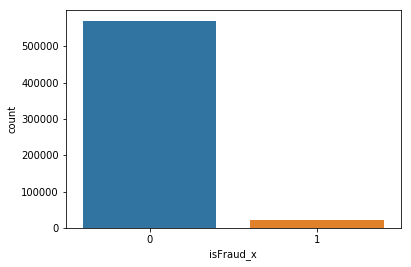

In [25]:
sns.countplot(train_df['isFraud_x'])

In [26]:
perc_fraud = len(train_df[train_df['isFraud_x']==1].index)*100/train_df.shape[0]
print("Percentage of Fradaulent records in dataset {:.2f}".format(perc_fraud) )

Percentage of Fradaulent records in dataset 3.50


In [27]:
# Check missing data - Many Columns have more than 50% NA/Null records
def missing_data(df) :
    count = df.isnull().sum()
    count1 = df.isnull().count()
    percent = (df.isnull().sum()) / (df.isnull().count()) * 100
    total = pd.concat([count, percent,count1], axis=1, keys = ['Count', 'Percent', 'actual count'])
    types = []
    for col in df.columns :
        dtypes = str(df[col].dtype)
        types.append(dtypes)
    total['dtypes'] = types
    
    return np.transpose(total)

missing_data(train_df)

,TransactionID,isFraud_x,TransactionDT_x,TransactionAmt_x,ProductCD_x,card1_x,card2_x,card3_x,card4_x,card5_x,...,V330_y,V331_y,V332_y,V333_y,V334_y,V335_y,V336_y,V337_y,V338_y,V339_y
Count,0,0,0,0,0,0,8933,1565,1577,4259,...,508189,508189,508189,508189,508189,508189,508189,508189,508189,508189
Percent,0,0,0,0,0,0,1.51268,0.265012,0.267044,0.721204,...,86.055,86.055,86.055,86.055,86.055,86.055,86.055,86.055,86.055,86.055
actual count,590540,590540,590540,590540,590540,590540,590540,590540,590540,590540,...,590540,590540,590540,590540,590540,590540,590540,590540,590540,590540
dtypes,int32,int8,int32,float16,object,int16,float16,float16,object,float16,...,float16,float32,float32,float32,float16,float16,float16,float32,float32,float32


In [37]:
null_percent = train_df.isnull().sum()/train_df.shape[0]*100
cols_to_drop = np.array(null_percent[null_percent > 50].index)
cols_to_drop

array(['dist1_x', 'dist2_x', 'R_emaildomain_x', 'D5_x', 'D6_x', 'D7_x',
       'D8_x', 'D9_x', 'D12_x', 'D13_x', 'D14_x', 'M5_x', 'M7_x', 'M8_x',
       'M9_x', 'V138_x', 'V139_x', 'V140_x', 'V141_x', 'V142_x', 'V143_x',
       'V144_x', 'V145_x', 'V146_x', 'V147_x', 'V148_x', 'V149_x',
       'V150_x', 'V151_x', 'V152_x', 'V153_x', 'V154_x', 'V155_x',
       'V156_x', 'V157_x', 'V158_x', 'V159_x', 'V160_x', 'V161_x',
       'V162_x', 'V163_x', 'V164_x', 'V165_x', 'V166_x', 'V167_x',
       'V168_x', 'V169_x', 'V170_x', 'V171_x', 'V172_x', 'V173_x',
       'V174_x', 'V175_x', 'V176_x', 'V177_x', 'V178_x', 'V179_x',
       'V180_x', 'V181_x', 'V182_x', 'V183_x', 'V184_x', 'V185_x',
       'V186_x', 'V187_x', 'V188_x', 'V189_x', 'V190_x', 'V191_x',
       'V192_x', 'V193_x', 'V194_x', 'V195_x', 'V196_x', 'V197_x',
       'V198_x', 'V199_x', 'V200_x', 'V201_x', 'V202_x', 'V203_x',
       'V204_x', 'V205_x', 'V206_x', 'V207_x', 'V208_x', 'V209_x',
       'V210_x', 'V211_x', 'V212_x', 'V213

In [40]:
train_df = train_df.drop(cols_to_drop, axis=1)
test_df = test_df.drop(cols_to_drop,axis=1)

KeyError: "['dist1_x' 'dist2_x' 'R_emaildomain_x' 'D5_x' 'D6_x' 'D7_x' 'D8_x' 'D9_x'\n 'D12_x' 'D13_x' 'D14_x' 'M5_x' 'M7_x' 'M8_x' 'M9_x' 'V138_x' 'V139_x'\n 'V140_x' 'V141_x' 'V142_x' 'V143_x' 'V144_x' 'V145_x' 'V146_x' 'V147_x'\n 'V148_x' 'V149_x' 'V150_x' 'V151_x' 'V152_x' 'V153_x' 'V154_x' 'V155_x'\n 'V156_x' 'V157_x' 'V158_x' 'V159_x' 'V160_x' 'V161_x' 'V162_x' 'V163_x'\n 'V164_x' 'V165_x' 'V166_x' 'V167_x' 'V168_x' 'V169_x' 'V170_x' 'V171_x'\n 'V172_x' 'V173_x' 'V174_x' 'V175_x' 'V176_x' 'V177_x' 'V178_x' 'V179_x'\n 'V180_x' 'V181_x' 'V182_x' 'V183_x' 'V184_x' 'V185_x' 'V186_x' 'V187_x'\n 'V188_x' 'V189_x' 'V190_x' 'V191_x' 'V192_x' 'V193_x' 'V194_x' 'V195_x'\n 'V196_x' 'V197_x' 'V198_x' 'V199_x' 'V200_x' 'V201_x' 'V202_x' 'V203_x'\n 'V204_x' 'V205_x' 'V206_x' 'V207_x' 'V208_x' 'V209_x' 'V210_x' 'V211_x'\n 'V212_x' 'V213_x' 'V214_x' 'V215_x' 'V216_x' 'V217_x' 'V218_x' 'V219_x'\n 'V220_x' 'V221_x' 'V222_x' 'V223_x' 'V224_x' 'V225_x' 'V226_x' 'V227_x'\n 'V228_x' 'V229_x' 'V230_x' 'V231_x' 'V232_x' 'V233_x' 'V234_x' 'V235_x'\n 'V236_x' 'V237_x' 'V238_x' 'V239_x' 'V240_x' 'V241_x' 'V242_x' 'V243_x'\n 'V244_x' 'V245_x' 'V246_x' 'V247_x' 'V248_x' 'V249_x' 'V250_x' 'V251_x'\n 'V252_x' 'V253_x' 'V254_x' 'V255_x' 'V256_x' 'V257_x' 'V258_x' 'V259_x'\n 'V260_x' 'V261_x' 'V262_x' 'V263_x' 'V264_x' 'V265_x' 'V266_x' 'V267_x'\n 'V268_x' 'V269_x' 'V270_x' 'V271_x' 'V272_x' 'V273_x' 'V274_x' 'V275_x'\n 'V276_x' 'V277_x' 'V278_x' 'V322_x' 'V323_x' 'V324_x' 'V325_x' 'V326_x'\n 'V327_x' 'V328_x' 'V329_x' 'V330_x' 'V331_x' 'V332_x' 'V333_x' 'V334_x'\n 'V335_x' 'V336_x' 'V337_x' 'V338_x' 'V339_x' 'dist1_y' 'dist2_y'\n 'R_emaildomain_y' 'D5_y' 'D6_y' 'D7_y' 'D8_y' 'D9_y' 'D12_y' 'D13_y'\n 'D14_y' 'M5_y' 'M7_y' 'M8_y' 'M9_y' 'V138_y' 'V139_y' 'V140_y' 'V141_y'\n 'V142_y' 'V143_y' 'V144_y' 'V145_y' 'V146_y' 'V147_y' 'V148_y' 'V149_y'\n 'V150_y' 'V151_y' 'V152_y' 'V153_y' 'V154_y' 'V155_y' 'V156_y' 'V157_y'\n 'V158_y' 'V159_y' 'V160_y' 'V161_y' 'V162_y' 'V163_y' 'V164_y' 'V165_y'\n 'V166_y' 'V167_y' 'V168_y' 'V169_y' 'V170_y' 'V171_y' 'V172_y' 'V173_y'\n 'V174_y' 'V175_y' 'V176_y' 'V177_y' 'V178_y' 'V179_y' 'V180_y' 'V181_y'\n 'V182_y' 'V183_y' 'V184_y' 'V185_y' 'V186_y' 'V187_y' 'V188_y' 'V189_y'\n 'V190_y' 'V191_y' 'V192_y' 'V193_y' 'V194_y' 'V195_y' 'V196_y' 'V197_y'\n 'V198_y' 'V199_y' 'V200_y' 'V201_y' 'V202_y' 'V203_y' 'V204_y' 'V205_y'\n 'V206_y' 'V207_y' 'V208_y' 'V209_y' 'V210_y' 'V211_y' 'V212_y' 'V213_y'\n 'V214_y' 'V215_y' 'V216_y' 'V217_y' 'V218_y' 'V219_y' 'V220_y' 'V221_y'\n 'V222_y' 'V223_y' 'V224_y' 'V225_y' 'V226_y' 'V227_y' 'V228_y' 'V229_y'\n 'V230_y' 'V231_y' 'V232_y' 'V233_y' 'V234_y' 'V235_y' 'V236_y' 'V237_y'\n 'V238_y' 'V239_y' 'V240_y' 'V241_y' 'V242_y' 'V243_y' 'V244_y' 'V245_y'\n 'V246_y' 'V247_y' 'V248_y' 'V249_y' 'V250_y' 'V251_y' 'V252_y' 'V253_y'\n 'V254_y' 'V255_y' 'V256_y' 'V257_y' 'V258_y' 'V259_y' 'V260_y' 'V261_y'\n 'V262_y' 'V263_y' 'V264_y' 'V265_y' 'V266_y' 'V267_y' 'V268_y' 'V269_y'\n 'V270_y' 'V271_y' 'V272_y' 'V273_y' 'V274_y' 'V275_y' 'V276_y' 'V277_y'\n 'V278_y' 'V322_y' 'V323_y' 'V324_y' 'V325_y' 'V326_y' 'V327_y' 'V328_y'\n 'V329_y' 'V330_y' 'V331_y' 'V332_y' 'V333_y' 'V334_y' 'V335_y' 'V336_y'\n 'V337_y' 'V338_y' 'V339_y'] not found in axis"

In [39]:
print(train_df.shape)
print(test_df.shape)

(590540, 787)
(506691, 433)


In [42]:
train_df.head()

,TransactionID,isFraud_x,TransactionDT_x,TransactionAmt_x,ProductCD_x,card1_x,card2_x,card3_x,card4_x,card5_x,...,V312_y,V313_y,V314_y,V315_y,V316_y,V317_y,V318_y,V319_y,V320_y,V321_y
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_df = train_df.fillna(-999)
test_df = test_df.fillna(-999)

In [ ]:
train_y = train_df['isFraud']
train_X = train_df.drop('isFraud', axis=1)

In [ ]:
for f in train_X.columns:
    if train_X[f].dtype=='object' or test_df[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_X[f].values) + list(test_df[f].values))
        train_X[f] = lbl.transform(list(train_X[f].values))
        test_df[f] = lbl.transform(list(test_df[f].values))

In [ ]:
lr = LogisticRegression()
lr.fit(train_X, train_y)

In [ ]:
submission = pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv',index_col='TransactionID')
submission['isFraud'] = lr.predict_proba(test_df)[:,1]
submission.to_csv('ab_submission.csv')
submission.head()